In [182]:
import feather
import os
import re
import pickle
import time
import datetime
import random

import numpy as np
import pandas as pd

from numba import jit

from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import matthews_corrcoef

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix

from ml_toolbox.xgboostmonitor_utils import *
import ml_toolbox.xgboostmonitor_utils as xgbm

%matplotlib inline

import xgboost as xgb
import subprocess

# Custom modules
import const
import func

## Load data

In [2]:
# Timestamps
t_data = func.load_data_file('train_date')
t_f_names = t_data['data']['feature_names'][1:]
t = t_data['data']['features']
y = t_data['data']['y']
del t_data

Returning <open file '/Volumes/My Book/kaggle_bosch/train_date.pkl', mode 'rb' at 0x117fe24b0>.pkl


In [269]:
# Timestamps test
t_data = func.load_data_file('test_date')
t_test = t_data['data']['features']
del t_data

Returning <open file '/Volumes/My Book/kaggle_bosch/test_date.pkl', mode 'rb' at 0x19b981660>.pkl


In [4]:
with open(const.CV, 'rb') as f:
    cv = pickle.load(f)
n_cv = len(cv)

In [5]:
t.shape

(1183747, 1156)

## Pre processing
Extract min time and max time from dense dataframe (much faster if not converting to sparse...copy code from previous)..

In [273]:
# Calculate error rate
n_folds = 5
n_t = 600
t_window = 1
random_state = 123456

In [274]:
def round_to(x, d2):
    return (x / d2).round(0) * d2

In [275]:
df2 = pd.DataFrame({'tmin': t.data[t.indptr[:-1]], 'tmax': t.max(1).todense().A1})
df2 = round_to(df2[['tmax','tmin']], t_window)
df2['R'] = y['Response'].values 
df2.head()

,tmax,tmin,R
0,87.0,82.0,0
1,1316.0,1313.0,0
2,1624.0,1619.0,0
3,1154.0,1149.0,0
4,606.0,603.0,0


In [276]:
# Extra time data from test for a comparison
df_test = pd.DataFrame({'tmin': t_test.data[t_test.indptr[:-1]], 'tmax': t_test.max(1).todense().A1})
df_test = round_to(df_test[['tmax','tmin']], t_window)
df_test.head()

,tmax,tmin
0,801.0,793.0
1,1060.0,1026.0
2,711.0,672.0
3,256.0,255.0
4,770.0,743.0


## Calculate folds

In [260]:
print('Mean R=1 count per group: {:.2f} ({:.0f})'.format(df2.groupby('tmax')['R'].sum().mean(), 
                                                     df2.groupby('tmax')['R'].count().mean()))
print('Mean t per bin: {}'.format(df2['tmax'].max()/n_t))

Mean R=1 count per group: 14.07 (2421)
Mean t per bin: 2.865


In [261]:
t_split = np.linspace(df2['tmax'].min(), df2['tmax'].max() + 0.01, n_t+1)

# Lazy...improve later!
cv = [([],[]),
      ([],[]),
      ([],[]),
      ([],[]),
      ([],[])]

cnt = 0
# Loop over all times and do fold per time
for i in range(n_t):
    t_min = t_split[i]
    t_max = t_split[i+1]
    
    
    n = df2[(df2['tmax']<t_max) & (df2['tmax']>=t_min)].index.values
    
    cnt += len(n)
    
    
    if n.shape[0]==0:
        continue
        
    y_t = y.iloc[n].Response
    
    if n.shape[0]<n_folds:
        for j in range(n_folds):
            a = cv[j][0] + list(n)
            b = cv[j][1]
            cv[j] = (a,b)
        continue
            
    
    #print t_min, t_max, len(y_t), sum(y_t)
    
    cv_t = StratifiedKFold(y_t, n_folds, True, 11111)
    
    for j, (itrain, itest) in enumerate(cv_t):
        a = cv[j][0] + list(y_t.iloc[itrain].index.values)
        b = cv[j][1] + list(y_t.iloc[itest].index.values)
        #print(len(a))
        #print(len(b))
        cv[j] = (a,b)
        
# Add nulls to CV
n = df2[df2['tmax'].isnull()].index.values

if n.shape[0]>0:
    y_t = y.iloc[n].Response
    cv_t = StratifiedKFold(y_t, n_folds, True, 11111)

    for j, (itrain, itest) in enumerate(cv_t):
        a = cv[j][0] + list(y_t.iloc[itrain].index.values)
        b = cv[j][1] + list(y_t.iloc[itest].index.values)
        #print(len(a))
        #print(len(b))
        cv[j] = (a,b)


In [262]:
# Do a quick sanity check
for i, (itrain, itest) in enumerate(cv):
    print('Fold: {} | n_samples: {} | n_test: {} | n_train: {} | union: {} | intersection: {}'.format(i,
                                                                           len(itrain) + len(itest), 
                                                                                                      len(itest),
                                                                                                      len(itrain),
                                                                           len(set(itrain) ^ set(itest)),
                                                                           len(set(itrain) & set(itest))))

Fold: 0 | n_samples: 1183747 | n_test: 237093 | n_train: 946654 | union: 1183747 | intersection: 0
Fold: 1 | n_samples: 1183747 | n_test: 236900 | n_train: 946847 | union: 1183747 | intersection: 0
Fold: 2 | n_samples: 1183747 | n_test: 236737 | n_train: 947010 | union: 1183747 | intersection: 0
Fold: 3 | n_samples: 1183747 | n_test: 236580 | n_train: 947167 | union: 1183747 | intersection: 0
Fold: 4 | n_samples: 1183747 | n_test: 236436 | n_train: 947311 | union: 1183747 | intersection: 0


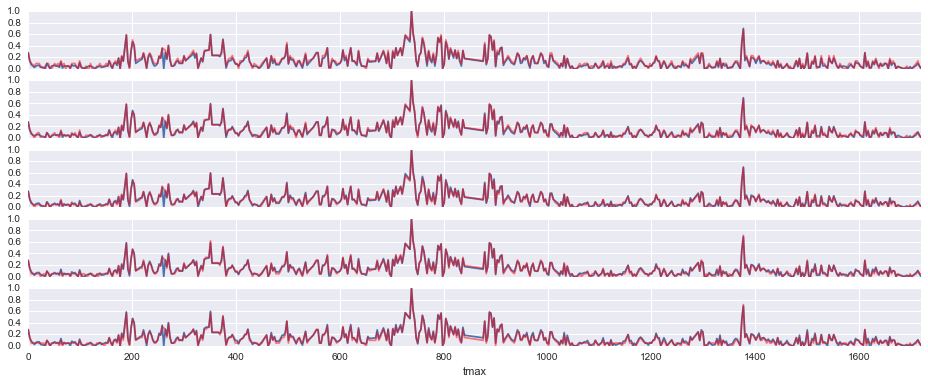

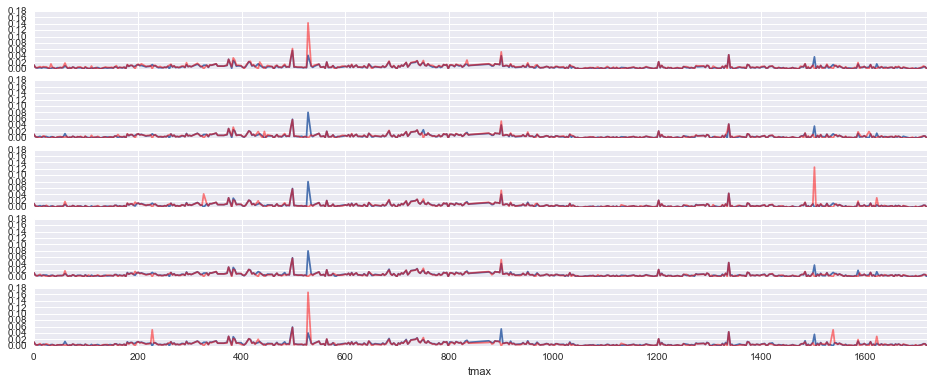

In [263]:
# Vizualize outcome
f, ax = plt.subplots(5,1,figsize=(16,6), sharex=True, sharey=True)
for i, (itrain, itest) in enumerate(cv):
    r_train = df2.iloc[itrain,:].groupby(['tmax'])['R'].sum()
    r_test = df2.iloc[itest,:].groupby(['tmax'])['R'].sum()
    (r_train/r_train.max()).plot(ax=ax[i])
    (r_test/r_test.max()).plot(ax=ax[i], color='r', alpha=0.5)
    
# Vizualize outcome
f, ax = plt.subplots(5,1,figsize=(16,6), sharex=True, sharey=True)
for i, (itrain, itest) in enumerate(cv):
    r_train = df2.iloc[itrain,:].groupby(['tmax'])['R'].mean()
    r_test = df2.iloc[itest,:].groupby(['tmax'])['R'].mean()
    (r_train).plot(ax=ax[i])
    (r_test).plot(ax=ax[i], color='r', alpha=0.5)

#df2.groupby(['tmax'])['R'].sum().plot(color='b', alpha=0.5)

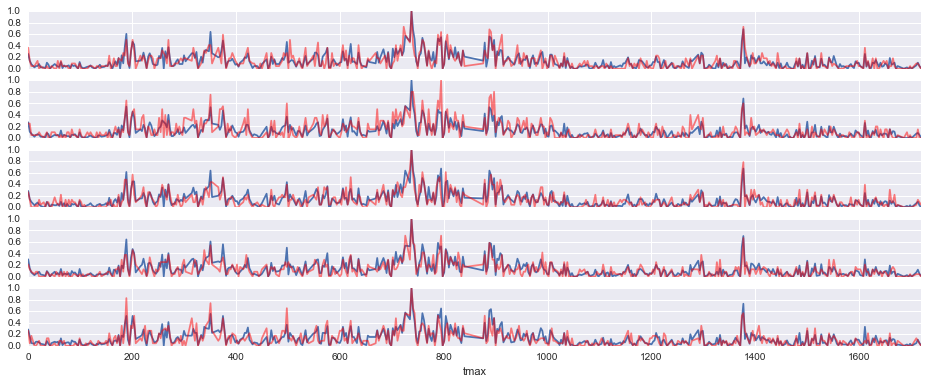

In [264]:
# Vizualize outcome
cv_bad = StratifiedKFold(y.Response.values, n_folds, True, 11111)
f, ax = plt.subplots(5,1,figsize=(16,6), sharex=True, sharey=True)
for i, (itrain, itest) in enumerate(cv_bad):
    r_train = df2.iloc[itrain,:].groupby(['tmax'])['R'].sum()
    r_test = df2.iloc[itest,:].groupby(['tmax'])['R'].sum()
    (r_train/r_train.max()).plot(ax=ax[i])
    (r_test/r_test.max()).plot(ax=ax[i], color='r', alpha=0.5)

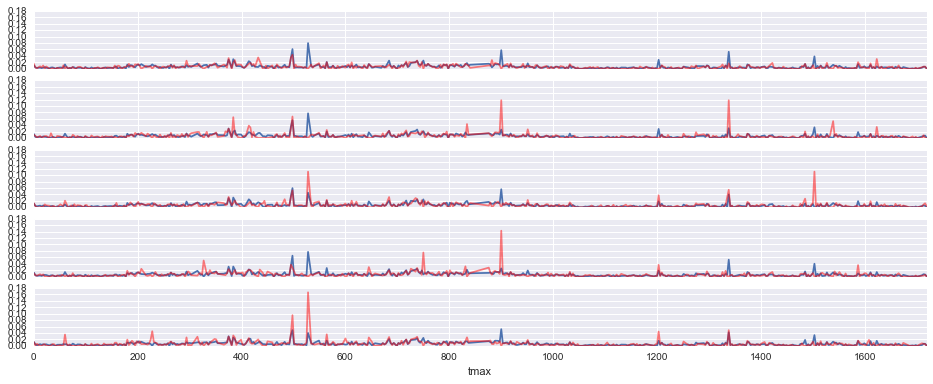

In [265]:
# Vizualize outcome
cv_bad = StratifiedKFold(y.Response.values, n_folds, True, 11111)
f, ax = plt.subplots(5,1,figsize=(16,6), sharex=True, sharey=True)
for i, (itrain, itest) in enumerate(cv_bad):
    r_train = df2.iloc[itrain,:].groupby(['tmax'])['R'].mean()
    r_test = df2.iloc[itest,:].groupby(['tmax'])['R'].mean()
    (r_train).plot(ax=ax[i])
    (r_test).plot(ax=ax[i], color='r', alpha=0.5)

### Compare test and train

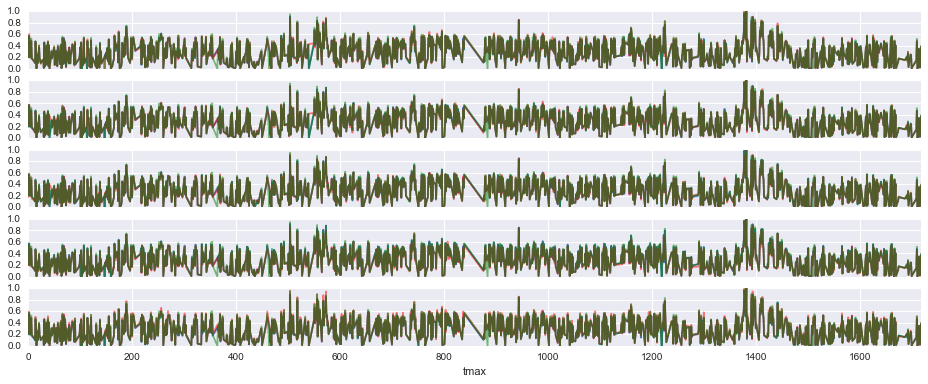

In [277]:
# Vizualize outcome
f, ax = plt.subplots(5,1,figsize=(16,6), sharex=True, sharey=True)
for i, (itrain, itest) in enumerate(cv):
    r_train = df2.iloc[itrain,:].groupby(['tmax'])['tmin'].count()
    r_val = df2.iloc[itest,:].groupby(['tmax'])['tmin'].count()
    r_test = df_test.groupby(['tmax'])['tmin'].count()
    (r_train/r_train.max()).plot(ax=ax[i])
    (r_val/r_val.max()).plot(ax=ax[i], color='r', alpha=0.5)
    (r_test/r_test.max()).plot(ax=ax[i], color='g', alpha=0.5)

### Store result as V2

In [242]:
with open(os.path.join(const.DATA_PATH, 'folds_V2.pkl'),'wb') as f:
    pickle.dump(cv, f, pickle.HIGHEST_PROTOCOL)

In [281]:
c[1]

[946,
 5283,
 5806,
 7674,
 12360,
 15395,
 27517,
 31287,
 35168,
 35378,
 40648,
 41939,
 42243,
 44000,
 44032,
 49006,
 50394,
 50989,
 51218,
 54670,
 55674,
 57396,
 57638,
 59114,
 63893,
 69607,
 76696,
 77234,
 78078,
 82501,
 90045,
 90478,
 96773,
 97418,
 99642,
 101105,
 101640,
 103129,
 106462,
 107113,
 107756,
 108447,
 109468,
 110239,
 111270,
 111966,
 114672,
 116031,
 118395,
 121403,
 123920,
 128340,
 129376,
 130888,
 130909,
 132548,
 132731,
 133649,
 138591,
 141389,
 143101,
 144421,
 144788,
 147721,
 151324,
 154358,
 157384,
 159139,
 161604,
 163813,
 167626,
 171355,
 175211,
 178998,
 181043,
 185674,
 187855,
 188141,
 193294,
 198851,
 199278,
 200820,
 201641,
 204560,
 208300,
 212277,
 213856,
 216518,
 217352,
 218938,
 220608,
 223531,
 231484,
 238833,
 246505,
 248566,
 249506,
 249687,
 251557,
 255420,
 255823,
 259056,
 259325,
 266193,
 266997,
 271960,
 273337,
 273564,
 277283,
 277611,
 279946,
 281897,
 294073,
 299067,
 300415,
 3055

In [284]:
for n, (itrain, itest) in enumerate(cv):
    pd.DataFrame({'sample_row': itest}).to_csv(os.path.join(const.DATA_PATH,'folds','folds_tbinned_{}.csv'.format(n)), index=False)